<a href="https://colab.research.google.com/github/kengmingcheng/Concrete_Strength_Prediction/blob/master/DNN_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap

     |████████████████████████████████| 327kB 16.0MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463903 sha256=b57eed509e0f22ad618791ccf98ec7525b40953c57a8f5085278cce14e643df8
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap


In [ ]:
# import datetime
from datetime import datetime
import os
import sys

import numpy as np
import pandas as pd
import math
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, MinMaxScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# shap
import shap

# tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Activation, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Add, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import callbacks
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

print(tf.__version__)
print(tf.keras.__version__)
print('Eager mode: %r' %tf.executing_eagerly())
tf.config.list_physical_devices('GPU')

sns.set_style('white')
RANDOM_SEED = 42
test_date = datetime.now().strftime('%Y%m%d')

2.3.0
2.4.0
Eager mode: True


In [ ]:
# import modules from github
if not os.path.isdir(r'/content/ucla_lab_modules'):
    !git clone https://github.com/kengmingcheng/ucla_lab_modules.git
else:
    !git -C ./content/ucla_lab_modules/ pull
from ucla_lab_modules.utilities import plot_history, std
from ucla_lab_modules.utilities import plot_mea_v_pred as measure_v_predict
from ucla_lab_modules.utils import to_MPa

Cloning into 'ucla_lab_modules'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 35 (delta 10), reused 31 (delta 8), pack-reused 0
Unpacking objects: 100% (35/35), done.


In [ ]:
%load_ext tensorboard

In [ ]:
# Read csv file into Colaboratory:
# Script runs on Colaboratory
if os.uname()[0] == 'Linux' and os.uname()[2].startswith('4.19'):

    from google.colab import files, drive#, auth

    Mount_DIR = r'/content/gdrive'
    drive.mount(Mount_DIR)

    # Set directories
    DATA_DIR = os.path.join(Mount_DIR, r'My Drive/UCLA/_Lab/ML_datasets')
    LOG_DIR = os.path.join(Mount_DIR, r'My Drive/UCLA/_Lab/Log/AdaNet', test_date)
    SAVE_DIR = os.path.join(Mount_DIR, r'My Drive/UCLA/_Lab/Results', test_date)
    if not os.path.isdir(SAVE_DIR):
        !mkdir -p "{SAVE_DIR}" 

# Script runs on local PC
else:
    Mount_DIR = os.path.realpath('.')
    DATA_DIR = os.path.realpath('.')
    LOG_DIR = os.path.join(Mount_DIR,r'Log/AdaNet', test_date)
    SAVE_DIR = os.path.join(Mount_DIR, r'Results', test_date)
    if not os.path.isdir(SAVE_DIR):
        !mkdir -p "{SAVE_DIR}"

Mounted at /content/gdrive


In [ ]:
FILE_NAME = 'Concrete_US concrete_individul strength_strong&weak&individual outlier removed.csv' #@param {type:"string"}
df_data = pd.read_csv(os.path.join(DATA_DIR, FILE_NAME), index_col = 0)
df_data.describe()

,W/C,W/CM,Fraction_cement,Fraction_coarse agg,Fraction_fine agg,Fraction_fly ash,Fraction_Slag,Entrainer,Accelerator,Retarder,Plasticizer,Viscosity,Load Size,Air Temp,Concrete Temp,Slump,7d Strength,28d Strength,28d Strength_1,28d Strength_2,28d Strength_3,Strength score,cov
count,8876.000000,8875.000000,8876.000000,8876.000000,8876.000000,8876.000000,8876.000000,8876.000000,8876.000000,8876.000000,8876.000000,8876.000000,8864.000000,8284.000000,8361.000000,8876.000000,3224.000000,8876.000000,8821.000000,7710.000000,6395.000000,8698.000000,8876.000000
mean,0.705326,0.394124,12.531752,40.491205,41.676077,2.978286,2.322680,0.020703,0.961438,0.629262,6.009911,0.422044,9.555223,61.471753,70.669107,6.103580,4501.724566,6488.254845,6486.565015,6404.465629,6398.431587,130.402981,0.020297
std,1.574189,0.090457,4.152901,11.946207,9.637921,2.159725,2.862153,0.154989,4.116885,1.401710,3.528158,1.230227,1.802188,9.042273,7.240603,16.335187,1662.925232,1694.479555,1706.966735,1611.845193,1522.204621,87.782582,0.018404
min,0.220000,0.200000,0.279018,0.000000,29.746508,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,31.000000,37.000000,0.000000,80.000000,87.000000,70.000000,100.000000,90.000000,83.750000,0.000000
25%,0.460000,0.340000,9.375000,42.550363,36.810406,2.178731,0.000000,0.000000,0.000000,0.000000,3.600000,0.000000,9.000000,55.000000,66.000000,4.500000,3340.000000,5487.000000,5470.000000,5490.000000,5490.000000,110.800000,0.007443
50%,0.550000,0.380000,12.263396,44.843049,39.023747,3.108108,0.000000,0.000000,0.000000,0.000000,5.050505,0.000000,10.000000,61.000000,71.000000,5.000000,4330.000000,6397.000000,6380.000000,6360.000000,6350.000000,123.250000,0.016608
75%,0.700000,0.430000,15.145119,45.830106,41.712347,3.939313,4.687077,0.000000,0.000000,0.000000,7.851100,0.000000,11.000000,67.000000,75.000000,6.500000,5490.000000,7340.000000,7350.000000,7250.000000,7250.000000,139.740000,0.028514
max,30.620000,1.000000,25.046268,54.408482,87.586662,17.412782,10.067959,3.939394,40.000000,13.000000,22.566285,10.000000,11.500000,103.000000,97.000000,1425.000000,12800.000000,14030.000000,14190.000000,14080.000000,13350.000000,5670.000000,0.367307


In [ ]:
df_data.head(3)

,W/C,W/CM,Fraction_cement,Fraction_coarse agg,Fraction_fine agg,Fraction_fly ash,Fraction_Slag,Entrainer,Accelerator,Retarder,Plasticizer,Viscosity,Load Size,Air Temp,Concrete Temp,Cement Type,Slump,7d Strength,28d Strength,28d Strength_1,28d Strength_2,28d Strength_3,Strength score,cov
3129,0.64,0.48,10.669570,45.590637,40.174197,3.565596,0.0,0.0,0.0,0.0,4.015296,0.0,11.0,60.0,65.0,TYPE V,4.5,NaN,8265,8450.0,8080.0,NaN,143.0,0.022384
9120,0.66,0.50,11.195652,45.516304,39.565217,3.722826,0.0,0.0,0.0,0.0,9.836066,0.0,10.0,50.0,57.0,TYPE V,5.0,NaN,5075,5150.0,5000.0,NaN,88.0,0.014778
509,23.57,0.76,0.279018,54.408482,36.941964,8.370536,0.0,0.0,0.0,0.0,0.000000,0.0,9.0,64.0,72.0,TYPE V,0.0,NaN,263,200.0,190.0,400.0,310.0,0.367307


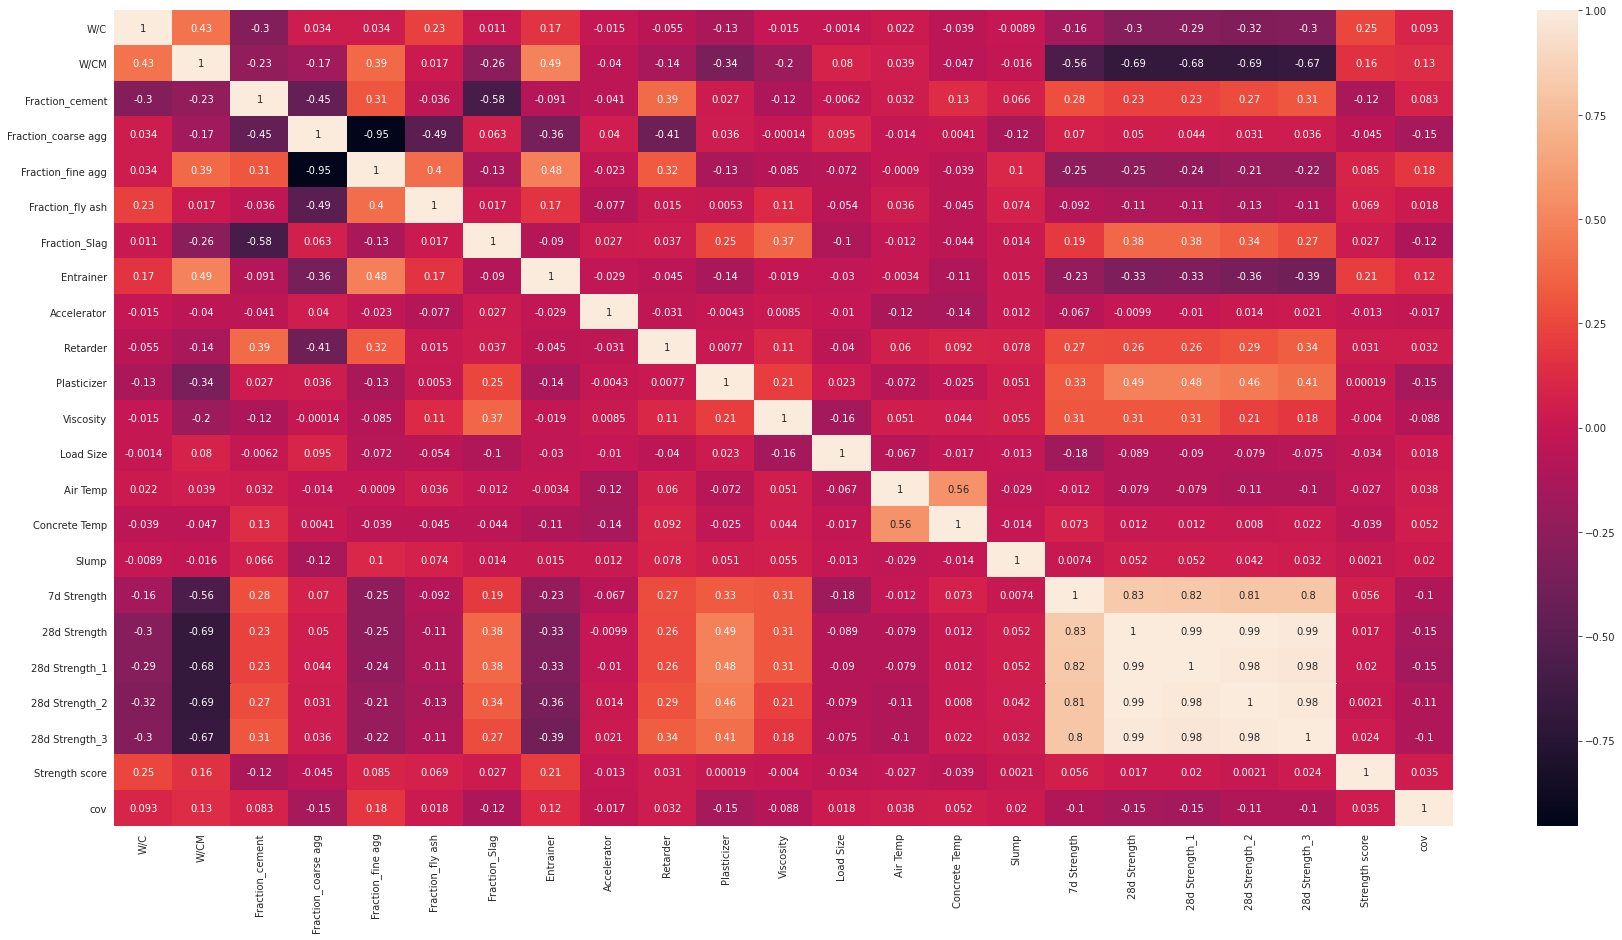

In [ ]:
plt.figure(figsize=[30,15])
sns.heatmap(df_data.corr(), annot=True)

In [ ]:
text = df_data[df_data['W/CM'] > 0]

In [ ]:
# Exploratory data analysis (EDA)
EDA = True
if EDA:
    catag_columns = ['Cement Type']#, 'Admixture type', 'Coarse aggregate type', 'Fine aggregate type']
    df_data = df_data[df_data['W/CM']>0]
    df_data = pd.get_dummies(df_data, catag_columns)

    df_data.fillna(0, inplace = True)
df_labels = df_data.columns

In [ ]:
df_data.describe()

,W/C,W/CM,Fraction_cement,Fraction_coarse agg,Fraction_fine agg,Fraction_fly ash,Fraction_Slag,Entrainer,Accelerator,Retarder,Plasticizer,Viscosity,Load Size,Air Temp,Concrete Temp,Slump,7d Strength,28d Strength,28d Strength_1,28d Strength_2,28d Strength_3,Strength score,cov,Cement Type_CSF,Cement Type_II/V,Cement Type_TYPE III,Cement Type_TYPE V
count,8875.000000,8875.000000,8875.000000,8875.000000,8875.000000,8875.000000,8875.000000,8875.000000,8875.000000,8875.000000,8875.000000,8875.000000,8875.000000,8875.000000,8875.000000,8875.000000,8875.000000,8875.000000,8875.000000,8875.000000,8875.000000,8875.000000,8875.000000,8875.000000,8875.000000,8875.000000,8875.000000
mean,0.705345,0.394124,12.530954,40.493094,41.674777,2.978233,2.322942,0.020705,0.961546,0.629332,6.010202,0.422092,9.542366,57.371380,66.567256,6.104043,1634.766197,6488.307606,6446.418028,5563.098592,4609.788169,127.790963,0.020298,0.000451,0.331155,0.021183,0.639099
std,1.574276,0.090457,4.152455,11.945554,9.637686,2.159841,2.862208,0.154998,4.117105,1.401773,3.528250,1.230288,1.834971,17.651945,17.955090,16.336050,2385.665672,1694.567735,1776.273757,2634.088011,3148.960302,88.804577,0.018405,0.021226,0.470655,0.144002,0.480289
min,0.220000,0.200000,0.279018,0.000000,29.746508,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,87.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.460000,0.340000,9.375000,42.564515,36.810043,2.178629,0.000000,0.000000,0.000000,0.000000,3.600000,0.000000,9.000000,54.000000,65.000000,4.500000,0.000000,5487.000000,5450.000000,4950.000000,0.000000,110.000000,0.007443,0.000000,0.000000,0.000000,0.000000
50%,0.550000,0.380000,12.263396,44.843049,39.023747,3.108108,0.000000,0.000000,0.000000,0.000000,5.050505,0.000000,10.000000,60.000000,70.000000,5.000000,0.000000,6397.000000,6370.000000,6110.000000,5690.000000,122.800000,0.016609,0.000000,0.000000,0.000000,1.000000
75%,0.700000,0.430000,15.145119,45.830106,41.712347,3.939313,4.687077,0.000000,0.000000,0.000000,7.851100,0.000000,11.000000,66.000000,75.000000,6.500000,3590.000000,7340.000000,7340.000000,7110.000000,6890.000000,139.200000,0.028517,0.000000,1.000000,0.000000,1.000000
max,30.620000,1.000000,25.046268,54.408482,87.586662,17.412782,10.067959,3.939394,40.000000,13.000000,22.566285,10.000000,11.500000,103.000000,97.000000,1425.000000,12800.000000,14030.000000,14190.000000,14080.000000,13350.000000,5670.000000,0.367307,1.000000,1.000000,1.000000,1.000000


In [ ]:
df_labels

Index(['W/C', 'W/CM', 'Fraction_cement', 'Fraction_coarse agg',
       'Fraction_fine agg', 'Fraction_fly ash', 'Fraction_Slag', 'Entrainer',
       'Accelerator', 'Retarder', 'Plasticizer', 'Viscosity', 'Load Size',
       'Air Temp', 'Concrete Temp', 'Slump', '7d Strength', '28d Strength',
       '28d Strength_1', '28d Strength_2', '28d Strength_3', 'Strength score',
       'cov', 'Cement Type_CSF', 'Cement Type_II/V', 'Cement Type_TYPE III',
       'Cement Type_TYPE V'],
      dtype='object')

In [ ]:
def _report(cv=False):
    record =[f"Test: {test_name}",
             f"Recording time: {datetime.now()}",
             f"Duriation: {processing_time}",
             f"Epoch: {epoch_n}",
             f"Batch Size: {BATCH_SIZE}",
             f"Activation: {activation}",
             f"Optimizer: {optimizer.get_config()['name']}\n"
             f"# of Layers: {num_of_layers}",
             f"# of Neurons: {list_of_neurons}",
             f"Dropout rates: {list_of_dropout}",
             f"# of CV: {None if not cv else cv_no}",
             "-------------------------",
             f"cv_r2: {r2_v}",
             f"cv_mse: {mse_v}",
             f"cv_rmse: {rmse_v}",
             "-------------------------",
             f"train_r2: {r2_t}",
             f"train_mse: {mse_t}",
             f"train_rmse: {rmse_t}",
             ]
    return record 

In [ ]:
# nn_model
class nn_builder:
    def __int__():
        Print("DNN object has been created!")

    def create_nn_model(self, 
                        input_shape, 
                        activation, 
                        list_of_neurons=[], 
                        list_of_dropout=[]):
        if not len(list_of_neurons) == len(list_of_dropout):
            raise Exception("# of layer of neurons and dropout don't match!")

        inp = Input(shape=(input_shape,))
        x = inp

        num_of_hidden_layer = num_of_layers
        for nodes, d_r in zip(list_of_neurons, list_of_dropout):
            x = self.hidden_layer(x, activation, nodes, d_r)

        out = Dense(1, activation="linear")(x)# 28 days
        self.model = Model(inputs= inp, outputs= [out])
        return self.model

    def create_duelInput_model(self, 
                               input_shape1, 
                               input_shape2, 
                               num_of_nodes, 
                               activation, 
                               list_of_dropout):
        inp = Input(shape=(input_shape,))

        x = Dense(num_of_nodes)(inp)
        x = Activation(activation)(x)
        x = BatchNormalization()(x)
        # x = Dropout(dropout_ratio)(x)

        num_of_hidden_layer = 16
        for i in range(num_of_hidden_layer):
            x = self.hidden_layer(x, num_of_nodes, activation, dropout_ratio)

        out = Dense(1, activation="linear")(x)# 28 days
        model = Model(inputs= inp, outputs= [out])
        return model

    def hidden_layer(self, 
                     input_data, 
                     activation, 
                     num_of_nodes, 
                     dropout_ratio):
        x = Dense(num_of_nodes)(input_data)
        x = Activation(activation)(x)
        x = BatchNormalization()(x)
        # Apply dropout layer if specified
        if dropout_ratio > 0 and dropout_ratio < 1:
            x = Dropout(dropout_ratio)(x)
        return x

In [ ]:
def shap_plot(index, inter_index="auto"):
    # select a set of background examples to take an expectation over
    background = train_input[np.random.choice(train_input.shape[0], 100, replace=False)]

    # explain predictions of the model on four images
    """
    Explain the influence of two specified layers
    """
    Explainer = shap.GradientExplainer(nn_model, train_input)
    # ...or pass tensors directly
    # e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
    shap_values = Explainer.shap_values(input_data)

    # plot the feature attributions
    f = plt.figure()
    shap.summary_plot(shap_values[0], input_data, feature_names=input_features, plot_type='dot')
    f.savefig(os.path.join(SAVE_DIR,test_name+"_summary_dot.png"), bbox_inches='tight', dpi=600)

    # plot the feature attributions
    f = plt.figure()
    shap.summary_plot(shap_values[0], input_data, feature_names=input_features, plot_type='bar')
    f.savefig(os.path.join(SAVE_DIR,test_name+"_summary_bar.png"), bbox_inches='tight', dpi=600)

    if type(index) is list:
        for i in index:
            shap.dependence_plot(i, shap_values[0], 
                            input_data, 
                            feature_names=input_features,
                            interaction_index="W/CM")
    else:
        shap.dependence_plot(index, shap_values[0], 
                input_data, 
                feature_names=input_features,
                interaction_index="W/CM")

In [ ]:
# Features
input_numericals=['W/CM', 'Fraction_cement', 'Fraction_coarse agg',
                  # 'Fraction_water', 'Fraction_slag',
                  'Fraction_Slag',
                  'Fraction_fine agg', 'Fraction_fly ash', 
                  'Entrainer', 'Plasticizer',
                  'Accelerator', 'Retarder',
                  # 'Load Size',
                  # 'Viscosity', 'Air Temp','Concrete Temp',
                  # '7d Strength',
                  ]

input_categoricals=[] #['Cement Type_CSF', 'Cement Type_II/V', 'Cement Type_TYPE III', 'Cement Type_TYPE V']

input_features = input_numericals + input_categoricals

input_labels = df_labels.drop([item for item in df_labels.values if item not in input_features])

# Standard Scaler from sklearn does seem to work better here than other Scalers
input_scaler = StandardScaler() # PowerTransformer() # StandardScaler() # MinMaxScaler() # RobustScaler()
# Standardize input data
input_data=np.concatenate((input_scaler.fit_transform(df_data[input_numericals]), df_data[input_categoricals]), axis=1)

y7_data=df_data[['7d Strength']]
y28_data=df_data[["28d Strength"]]

#following parameters should be adjusted to control the loss function
#if all parameters are zero, attractors do not work. (-> simple neural network)
m1=1
m2=4
m3=1

target_scaler = StandardScaler()
target1_scaler = StandardScaler()
# Standardize target values
target_data=y28_data
target_data_1=y7_data
target_data=target_scaler.fit_transform(target_data)
target_data_1=m1*(target1_scaler.fit_transform(target_data_1))

# Simple split to provide us a validation set to do our CV checks with
full_train_index, cv_index = train_test_split(np.arange(len(df_data)), random_state= 42, test_size=0.2)

# show input data shape
print(input_data.shape)

(8875, 10)


In [ ]:
def train_and_evaluate():
    # Build a Neural Network
    new_model = nn_builder()
    nn_model=new_model.create_nn_model(train_input.shape[1], activation, list_of_neurons, list_of_dropout)

    # If retrain==False, then we load a previous saved model as a starting point.
    if not retrain:
        nn_model = load_model(model_name_rd)

    # compile
    nn_model.compile(optimizer=optimizer, loss=Loss_function, metrics=metrics)
    # nn_model.summary()
    
    # Callback for Early Stopping... 
    # May want to raise the min_delta for small numbers of epochs
    # es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0000001, patience=8,verbose=1, mode='auto', restore_best_weights=True)
    es = callbacks.EarlyStopping(monitor='val_loss', 
                                min_delta=es_delta, 
                                patience=10, 
                                verbose=1, 
                                mode='auto', 
                                restore_best_weights=True)
    # Callback for Reducing the Learning Rate... when the monitor levels out for 'patience' epochs, then the LR is reduced
    rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                    factor=1/3, 
                                    patience=7, 
                                    min_lr=1e-6, 
                                    min_delta=reduce_delta, 
                                    mode='auto', 
                                    verbose=0) #0.0001
    # Save the best value of the model for future use
    sv_mod = callbacks.ModelCheckpoint(model_name_wrt, 
                                        monitor='val_loss', 
                                        save_best_only=True, 
                                        save_weights_only=False, 
                                        mode='auto', 
                                        save_freq='epoch',
                                        period=1, 
                                        verbose=0)
    # Tensorboard
    tb = callbacks.TensorBoard(log_dir=os.path.join(LOG_DIR, test_name), 
                                histogram_freq=1,
                                write_graph=True, 
                                write_images=False,
                                update_freq='epoch', 
                                profile_batch=2, 
                                embeddings_freq=0,
                                embeddings_metadata=None)

    # Training model
    hist = nn_model.fit(x=train_input,
                        y=train_target,
                        validation_data=(cv_input,cv_target),
                        callbacks=[es, rlr, sv_mod, tb],
                        epochs=epoch_n,
                        batch_size=BATCH_SIZE,
                        verbose=verbose)
    cv_pred=nn_model.predict(cv_input)
    train_pred=nn_model.predict(train_input)

    return hist, cv_pred, train_pred, nn_model
  

No cross validation!
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Restoring model weights from the end of the best epoch.
Epoch 00128: early stopping


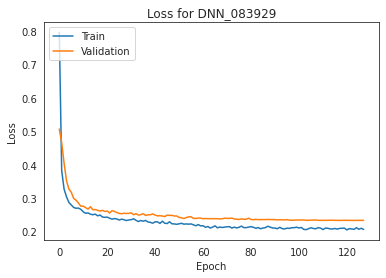

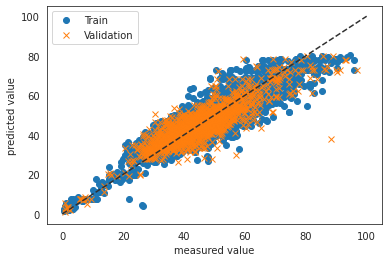

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


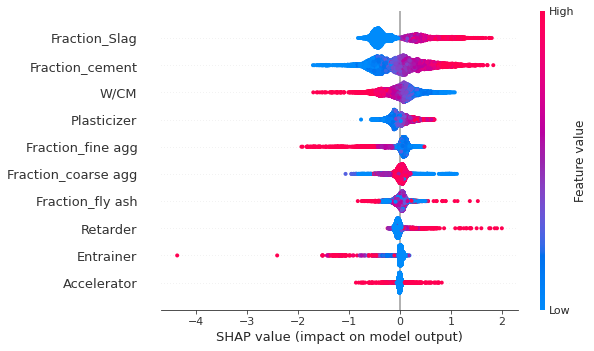

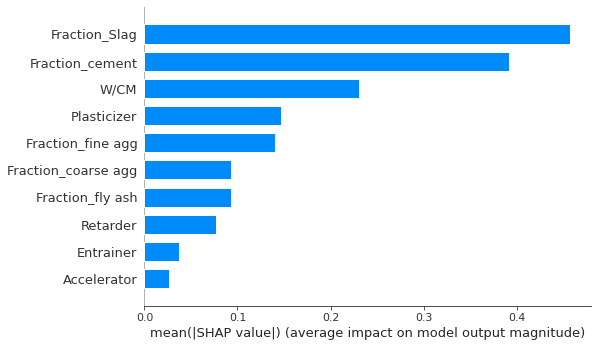

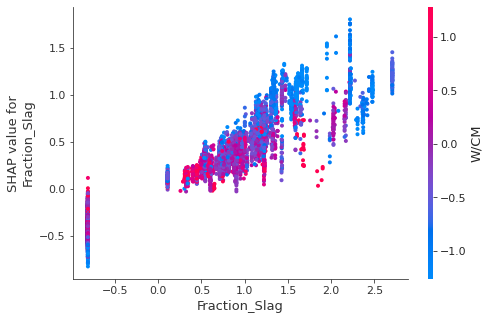

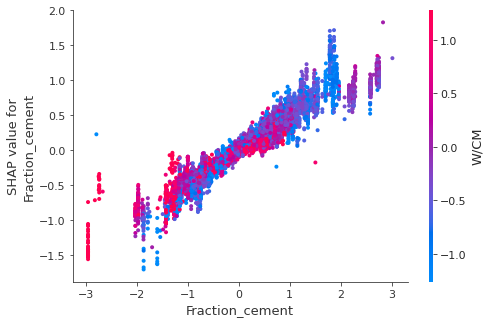

Test: DNN_083929
Recording time: 2020-12-11 08:41:18.769066
Duriation: 0:00:41.057182
Epoch: 10000
Batch Size: 128
Activation: tanh
Optimizer: Adam
# of Layers: 2
# of Neurons: [32, 16]
Dropout rates: [0, 0]
# of CV: None
-------------------------
cv_r2: 0.7620936845373758
cv_mse: 31.83823051570256
cv_rmse: 5.6425375954177355
-------------------------
train_r2: 0.8064087571091318
train_mse: 26.55244246717118
train_rmse: 5.152906215639013


Training # 1
Cross-Validation: False
R2 mean: 0.7620936845373758 , STD: 0
MSE mean: 31.83823051570256 , STD: 0
RMSE mean: 5.6425375954177355, STD: 0


R2 (cross validation): 0.7620936845373758
RMSE (cross validation): 5.6425375954177355


In [ ]:
#@title DNN parameters

list_of_neurons = [32, 16]
list_of_dropout = [0 for i in range(len(list_of_neurons))]

num_of_layers =  len(list_of_neurons)

epoch_n = 10000 #@param {type:"integer"}
BATCH_SIZE = 128 #@param {type:"integer"}
reduce_delta = 0.0001 #@param {type:"number"}
es_delta = 0.000001 #@param {type:"number"}
cross_validation = False #@param {type:"boolean"}
# Set to True if we want to train from scratch.  
# False will reuse saved models as a starting point.
retrain = True
verbose = 0
numOfTraining = 1

# list of hyperparameters
optimizer_list = ['adadelta', 'adagrad', 'adam', 'ftrl', 'nadam', 'rmsprop', 'sgd']
activation_list = ['elu', 'hard_sigmoid', 'linear', 'relu', 'selu',
                   'sigmoid', 'softmax', 'softplus', 'softsign', 'tanh']
loss_list = ['KLD', 'MAPE', 'MAE', 'MSLE', 'MSE', 'binary_crossentropy', 
             'hinge', 'squared_hinge']


text_file_name = 'DNN-' + test_date + '.txt'
start_time=datetime.now()
test_name = "DNN_" + start_time.strftime('%H%M%S')

cv_score=[]
cv_score_total=0

mse_sum = []
rmse_sum = []
r2_sum = []

if not cross_validation:
    print("No cross validation!")

for i in range(1,2,1):
    start_time=datetime.now()
    # list_of_neurons = [32 for l in range(i)]
    # list_of_dropout = [0 for l in range(len(list_of_neurons))]

    for j in range(0,1,1):
        mse_cv_result = []
        rmse_cv_result = []
        r2_cv_result = []
        cv_no = 0

        # Split data into 5-fold cross validation
        Kfold = KFold(n_splits=5, random_state=42, shuffle=True)
        Kfold_split = Kfold.split(np.arange(len(df_data)))
        # Split data
        reg_split = train_test_split(np.arange(len(df_data)),
                                     test_size = 0.2,
                                     random_state = 42)

        Split = Kfold_split if cross_validation else [reg_split]


        for train_index, cv_index in Split:
            cv_no += 1

            folder_name = "DNN_" + start_time.strftime('%H%M%S')
            test_name = folder_name + (" CV_%s" %(cv_no) if cross_validation else "")

            # Model settings
            Loss_function = 'mean_squared_error'
            optimizer = Adam(learning_rate=0.001)
            metrics = [tf.keras.metrics.RootMeanSquaredError()]

            # activation = LeakyReLU(alpha = 0.05)
            activation = "tanh"

            # Training and test dataset
            train_input=input_data[train_index]
            cv_input=input_data[cv_index]

            train_target=target_data[train_index]
            cv_target=target_data[cv_index]

            train_target_1=target_data_1[train_index]
            cv_target_1=target_data_1[cv_index]

            # Loop through each molecule type
            if not os.path.isdir(os.path.join(LOG_DIR, folder_name, r'model')):
                !mkdir -p "{os.path.join(LOG_DIR, folder_name, r'model')}"
            model_name_rd = (os.path.join(LOG_DIR, folder_name, r'model/concrete_model_%s.hdf5'%cv_no))
            model_name_wrt = (os.path.join(LOG_DIR, folder_name, r'model/concrete_model_%s.hdf5'%cv_no))

            # Train model
            history, cv_predict, train_predict, nn_model = train_and_evaluate()

            # Training duration
            end_time=datetime.now()
            processing_time = end_time - start_time

            # scaler inverse transform (PSI to MPa) (*0.00689476)
            cv_predict_inverse = to_MPa(target_scaler.inverse_transform(cv_predict))
            train_predict_inverse = to_MPa(target_scaler.inverse_transform(train_predict))
            cv_target_inverse = to_MPa(target_scaler.inverse_transform(cv_target))
            train_target_inverse= to_MPa(target_scaler.inverse_transform(train_target))
            cv_target_1_inverse = to_MPa(target_scaler.inverse_transform(cv_target_1))
            train_target_1_inverse = to_MPa(target_scaler.inverse_transform(train_target_1))

            # Plot loss history
            plot_history(history, test_name, save_path=SAVE_DIR)

            # Plot distrbution of true and predicted values
            measure_v_predict(train_target_inverse, 
                            train_predict_inverse, 
                            cv_target_inverse, 
                            cv_predict_inverse,
                            title = test_name,
                            save_path = SAVE_DIR)
            

            # Shap analysis and plots
            shap_plot(['Fraction_Slag','Fraction_cement'])

            # Validation performance
            r2_v = r2_score(cv_target_inverse, cv_predict_inverse)
            mse_v = mean_squared_error(cv_target_inverse, cv_predict_inverse)
            rmse_v = math.sqrt(mse_v)
            # Training performance
            r2_t = r2_score(train_target_inverse, train_predict_inverse)
            mse_t = mean_squared_error(train_target_inverse, train_predict_inverse)
            rmse_t = math.sqrt(mse_t)

            record =_report(cross_validation)
            
            with open(os.path.join(SAVE_DIR, text_file_name), "a+") as file:
                for line in record:
                    file.write(line + "\n")
                    print(line)
                file.write("\n")
                print('\n')

            # cross validation recording
            r2_cv_result.append(r2_v)
            mse_cv_result.append(mse_v)
            rmse_cv_result.append(rmse_v)
            r2_sum.append(r2_v)
            mse_sum.append(mse_v)
            rmse_sum.append(rmse_v)

        Summary = [f"Training # {i}",
                   f"Cross-Validation: {cross_validation}",
                   f"R2 mean: {sum(r2_cv_result)/cv_no} , STD: {std(r2_cv_result)}",
                   f"MSE mean: {sum(mse_cv_result)/cv_no} , STD: {std(mse_cv_result)}",
                   f"RMSE mean: {sum(rmse_cv_result)/cv_no}, STD: {std(rmse_cv_result)}",
                   ]
        with open(os.path.join(SAVE_DIR, text_file_name), "a+") as file:
            for line in Summary:
                file.write(line + "\n")
                print(line)
                file.write("\n")
            print('\n')
  
    retrain = True

    print("R2 (cross validation): {}".format(sum(r2_sum)/cv_no/numOfTraining))
    print("RMSE (cross validation): {}".format(sum(rmse_sum)/cv_no/numOfTraining))

In [ ]:
# %tensorboard --logdir "{LOG_DIR}"

In [ ]:
def interpolate_datas(baseline,
                     data,
                     alphas):
    alphas_x = alphas[:, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(data, axis=0)
    delta = input_x - baseline_x
    datas = baseline_x + alphas_x * delta
    return datas

def compute_gradients(datas,
                      target_class_idx = 0):
    with tf.GradientTape() as tape:
        tape.watch(datas)
        logit = nn_model(datas)
        probs = logit

    return tape.gradient(probs, datas)

def integral_approximation(gradients):
    # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients

def gradients_for_regression(baseline,
                             data,
                             m_steps=100,
                             batch_size=32,
                             show_measured_data=True):
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

    interpolated_data = interpolate_datas(baseline, data, alphas)
    path_gradients = compute_gradients(datas = interpolated_data)

    prediction = nn_model(interpolated_data)


    plt.figure(figsize=(5,10))
    # predicted value along with interpolated data points
    ax1 = plt.subplot(2,1,1)
    ax1.plot(alphas, to_MPa(target_scaler.inverse_transform(prediction)))
    # show measured target value on the plot
    if show_measured_data:
        ax1.plot(1, to_MPa(target_scaler.inverse_transform([target_data[selected_idx]])), 'ro')
        ax1.text(0.8, to_MPa(target_scaler.inverse_transform([target_data[selected_idx]])), 'Measured\nvalue')
    ax1.set_xlabel('alpha')
    ax1.set_ylabel('standardized strength (MPa)')
    # integrated gredients along with interpolated data points
    ax2 = plt.subplot(2,1,2)
    avg_grads = tf.reduce_mean(path_gradients, axis=1)
    avg_grads_norm = (avg_grads-tf.math.reduce_min(avg_grads))/(tf.math.reduce_max(avg_grads)-tf.reduce_min(avg_grads))
    ax2.plot(alphas, avg_grads)
    ax2.set_xlabel('alpha')
    ax2.set_ylabel('average gardients')

    plt.show()

    print('----------------------------------------------')
    # Gredients respected to each feature
    fig = plt.figure(figsize=(20,8))
    for i in range(path_gradients[0].shape[0]):
        plt.subplot(2, (path_gradients[0].shape[0]+1)//2, i+1)
        plt.title(input_features[i])
        x_axis = input_scaler.inverse_transform(interpolated_data)
        plt.plot(x_axis[:,i], path_gradients[:,i])
        
    plt.tight_layout()
    plt.show()

    print('\n\n')

@tf.function
def integrated_gradients(baseline,
                         data,
                         target_class_idx=0,
                         m_steps=100,
                         batch_size=51):
    # 1. Generate alphas.
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

    # Initialize TensorArray outside loop to collect gradients.    
    gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)

    # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
    for alpha in tf.range(0, len(alphas), batch_size):
        from_ = alpha
        to = tf.minimum(from_ + batch_size, len(alphas))
        alpha_batch = alphas[from_:to]

        # 2. Generate interpolated inputs between baseline and input.
        interpolated_path_input_batch = interpolate_datas(baseline=baseline,
                                                            data=data,
                                                            alphas=alpha_batch)

        # 3. Compute gradients between model outputs and interpolated inputs.
        gradient_batch = compute_gradients(datas=interpolated_path_input_batch,
                                            target_class_idx=target_class_idx)

        # Write batch indices and gradients to extend TensorArray.
        gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)    

    # Stack path gradients together row-wise into single tensor.
    total_gradients = gradient_batches.stack()

    # 4. Integral approximation through averaging gradients.
    avg_gradients = integral_approximation(gradients=total_gradients)

    # 5. Scale integrated gradients with respect to input.
    integrated_gradients = (data - baseline) * avg_gradients

    return integrated_gradients

In [ ]:
def shap_clone(datas,
               baseline_data,
               n_samples=200):

    if len(datas.shape()) > 1:
        # generating n_sample of noised data
        phis=[]
        phi_vars=[]
        for k in range(len(datas)):
            phis.append(np.zeros(datas[k].shape))
            phi_vars.append(np.zeros(datas[k].shape))
        for j in range(datas[0].shape[0]):

            for k in range(n_samples):
                rind = np.random.choice(baseline_data[0].shape[0])
                t = np.random.uniform()

                for l in range(datas.shape[0]):
                    x = datas[l][j]
                    samples_input[l][k] = t*x - (1-t)*baseline_data[l][rind]
                    samples_delta[l][k] = x - baseline_data[l][rind]
            grads = []
            batch = [sample_input[l]]

    gradient_batch = compute_gradients(datas=interpolated_path_input_batch,
                                        target_class_idx=target_class_idx)
    
    # 1. Generate alphas.
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

    # Initialize TensorArray outside loop to collect gradients.    
    gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)

    # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
    for alpha in tf.range(0, len(alphas), batch_size):
        from_ = alpha
        to = tf.minimum(from_ + batch_size, len(alphas))
        alpha_batch = alphas[from_:to]


In [ ]:
baseline_reg = tf.zeros(shape=(10,))
IGs = np.zeros(shape=[input_data.shape[0],input_data[0].shape[0]])
for i in range(len(input_data)):
    # print(f'Random index: {i}')
    selected_idx = i
    ig_data = input_data[selected_idx]
    ig_data = tf.convert_to_tensor(ig_data, dtype=tf.float32)

    ig = integrated_gradients(baseline_reg, ig_data)
    IGs[i] = ig
    # gradients_for_regression(baseline_reg,ig_data)

In [ ]:
rd_pick=np.random.choice(len(df_data),1)
baseline_reg = tf.zeros(shape=(10,))
if True:
    baseline_reg = tf.convert_to_tensor(input_data.min(axis=0),  dtype=tf.float32)

Random index: 552


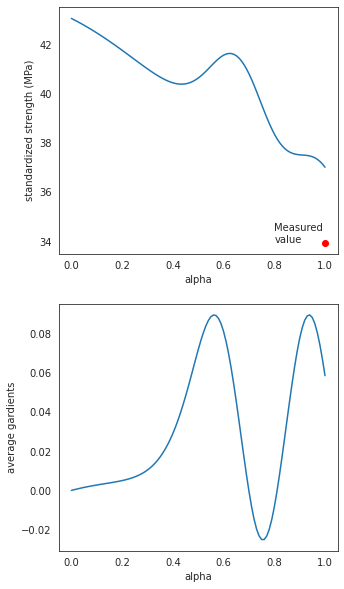

----------------------------------------------


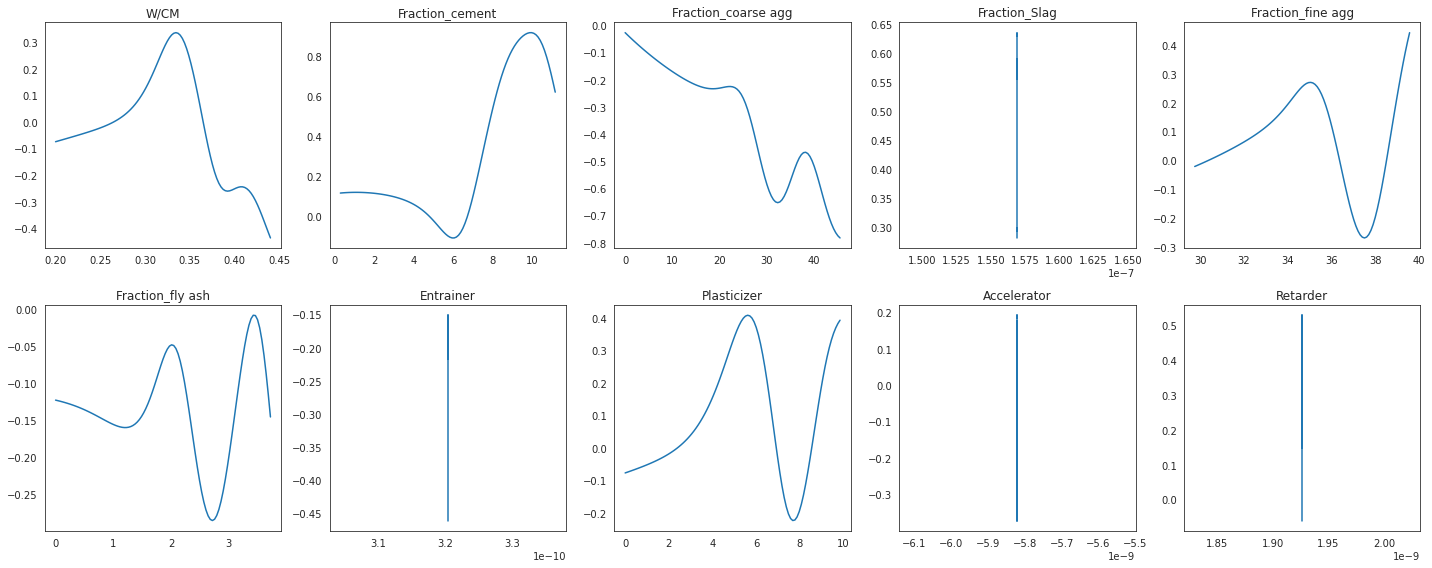

In [ ]:
for i in rd_pick:
    print(f'Random index: {i}')
    selected_idx = i
    ig_data = input_data[selected_idx]
    ig_data = tf.convert_to_tensor(ig_data, dtype=tf.float32)

    gradients_for_regression(baseline_reg,ig_data)

iter. # of maximum: 1


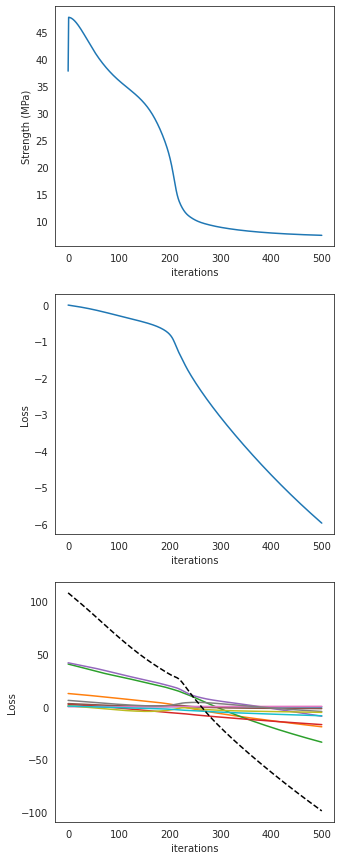

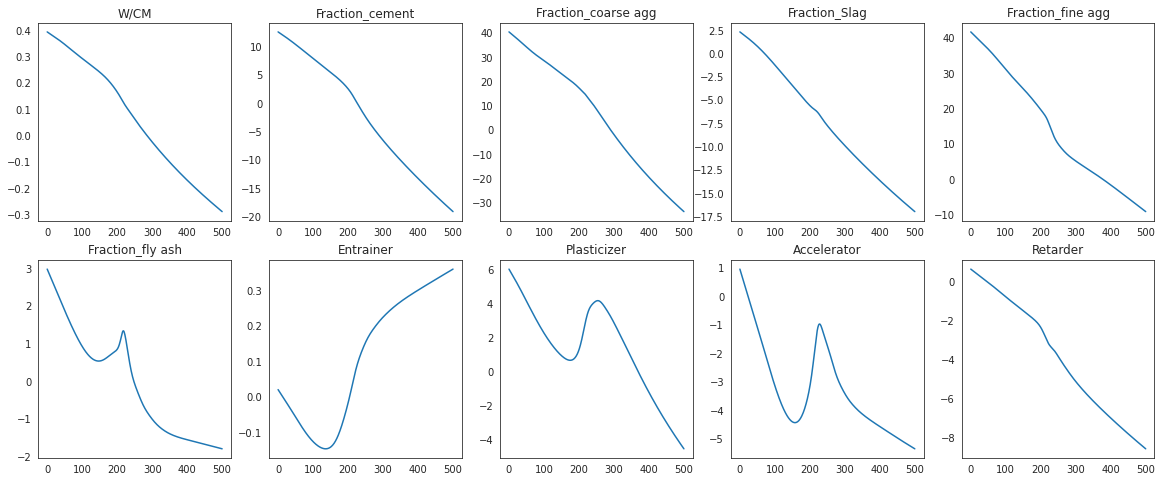

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
# baseline_reg1 = tf.convert_to_tensor(input_data.min(axis=0),  dtype=tf.float32)
var1 = tf.zeros(shape=(1,10))
# var1 = baseline_reg1
# var1 = tf.expand_dims(var1, axis=0)
var1 = tf.Variable(var1)
# var1 = tf.Variable(10.0)
loss_fn = lambda: tf.constant(1.0) * (tf.reduce_sum(var1)) / ((nn_model(var1)*target_scaler.scale_[0]+target_scaler.mean_[0]) * 0.00689476)
opt_search_prediction = to_MPa(target_scaler.inverse_transform([nn_model(input_scaler.transform(var1.numpy())).numpy()[0][0]]))
opt_loss_history = loss_fn().numpy()[0]
opt_var_history = var1.numpy()*input_scaler.scale_+input_scaler.mean_

# loss_fn = lambda: (var1 ** 2)/2.0
for _ in range(500):
    opt.minimize(loss_fn, [var1])
    var_out = var1
    opt_search_prediction = np.concatenate((opt_search_prediction, to_MPa(target_scaler.inverse_transform([nn_model(var_out).numpy()[0][0]]))), axis=0)
    opt_var_history = np.concatenate((opt_var_history, var1.numpy()*input_scaler.scale_+input_scaler.mean_), axis = 0)
    opt_loss_history = np.concatenate((opt_loss_history, loss_fn().numpy()[0]), axis=0)
# for _ in range(10):
#     with tf.GradientTape() as tape:
#         tape.watch(var1)
#         logit = nn_model(var1)

#     grads = tape.gradient(logit, var1)
#     opt.apply_gradients(zip(grads, [var1]))
indx_max = np.argmax(opt_search_prediction)
print(f"iter. # of maximum: {indx_max}")

fig = plt.figure(figsize=(5,15))
ax1 = plt.subplot(3,1,1)
ax1.plot(opt_search_prediction)
ax1.set_xlabel('iterations')
ax1.set_ylabel('Strength (MPa)')
ax2 = plt.subplot(3,1,2)
ax2.plot(opt_loss_history)
ax2.set_xlabel("iterations")
ax2.set_ylabel("Loss")
ax3 = plt.subplot(3,1,3)
ax3.plot(opt_var_history)
ax3.plot(np.sum(opt_var_history, axis=1), 'k--')
ax3.set_xlabel("iterations")
ax3.set_ylabel("Loss")
fig.show()

fig = plt.figure(figsize=(20,8))
for i in range(opt_var_history[0].shape[0]):
    plt.subplot(2, (opt_var_history[0].shape[0]+1)//2, i+1)
    plt.title(input_features[i])
    plt.plot(opt_var_history[:,i])
fig.show()

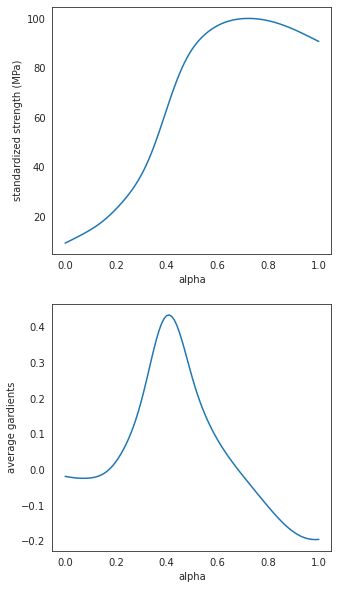

----------------------------------------------


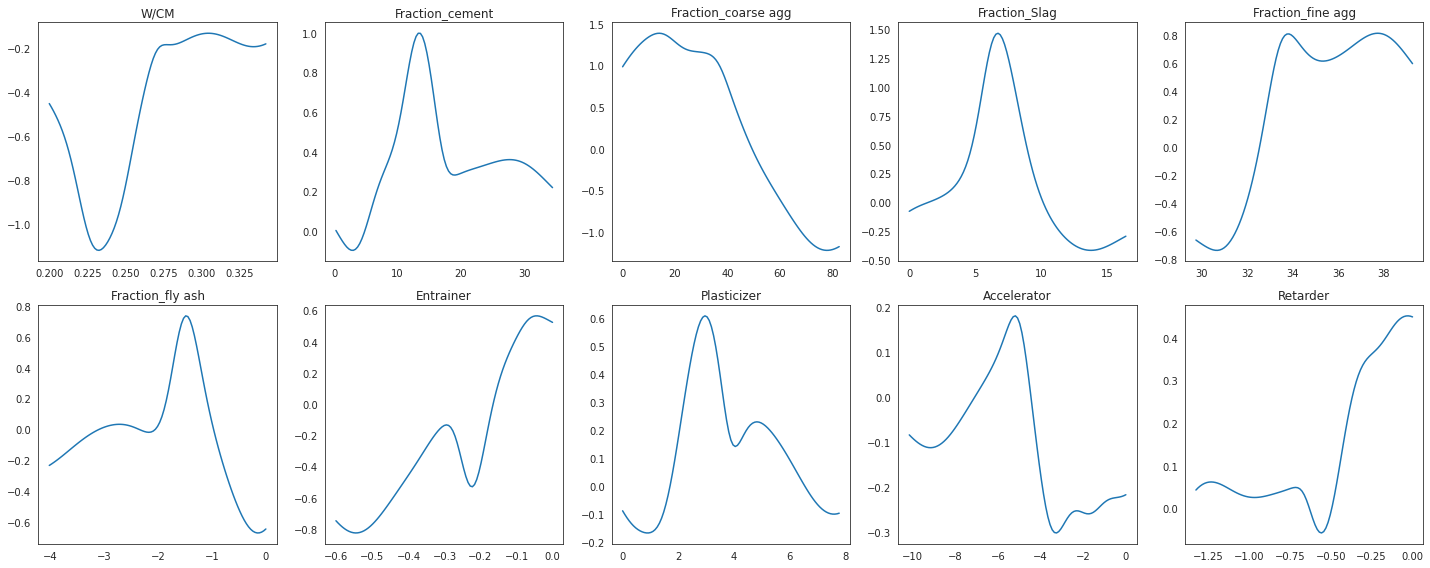

In [ ]:
reform_pseudo_data = False
baseline_reg2 = tf.convert_to_tensor(input_data.min(axis=0),  dtype=tf.float32)
# pseudo_data = tf.convert_to_tensor(input_data.max(axis=0),  dtype=tf.float32)
pseudo_data = (opt_var_history[indx_max]-input_scaler.mean_)/input_scaler.scale_
pseudo_data = tf.convert_to_tensor(pseudo_data *2 - baseline_reg2, dtype=tf.float32)
if reform_pseudo_data:
    pseudo_data = tf.expand_dims(pseudo_data, axis=0)
    pseudo_pred = nn_model.predict(pseudo_data)
# pseudo_data = np.amax(input_data, axis=0)
# pseudo_data = tf.convert_to_tensor(pseudo_data, dtype=tf.float32)
gradients_for_regression(baseline_reg2,
                         pseudo_data,
                         show_measured_data=False)

In [ ]:
END_TRAINING = True
if END_TRAINING:
  drive.flush_and_unmount()
  drive.mount(Mount_DIR)